In [1]:
import anndata as ad
from anndata import AnnData
import numpy as np
from skimage.morphology import convex_hull_image 
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import ot

In [2]:
adata_exp0 = ad.read_h5ad('C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/spatial/counts_CPc_exp0_BA28.h5ad')
adata_Yao = ad.read_h5ad(
    'C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/sc/Yao_150kcells_subsample_with_annotations_sparse_subset.h5ad')

In [179]:
#linear sum assignment approach
#spot distribution:
adata_sp = adata_exp0
df = adata_sp.uns["spots"]
unique_cell_ids = adata_sp.obs["cell_id"]
adata_sp.obs["uniform_cell"] = np.nan

spots = df.loc[df["cell"] == 1855].copy()
spots["x"], spots["y"] = [spots["x"].round().astype(int), spots["y"].round().astype(int)]      
[x_min, x_max, y_min, y_max] = [spots["x"].min(),spots["x"].max(),spots["y"].min(),spots["y"].max()]
spots["x"], spots["y"] = spots["x"]-x_min, spots["y"]-y_min


seg_mask = np.zeros((x_max-x_min+1,y_max-y_min+1))
seg_mask[spots["x"].values.tolist(), spots["y"].values.tolist()] = 1       #?spot mir Koord. (x,y) wird geplottet bei (y,x)
cell = convex_hull_image(seg_mask)  

spot_distr = np.histogram2d(spots["x"], spots["y"], [x_max-x_min+1,y_max-y_min+1])[0]

n_spots = len(spots["x"])
n_pixs = np.sum(cell)

a = spot_distr[cell].reshape(-1,1)
b = (np.ones(n_pixs)*n_spots/n_pixs).reshape(-1,1)

indices = cell.nonzero()
coords = np.transpose(indices)
eucl_dist = cdist(coords,coords)
distr_diff = cdist(a,b)

work = eucl_dist + distr_diff                                                                   
row_ind, col_ind = linear_sum_assignment(work)
work[row_ind, col_ind].sum()


1539.221174004193

In [171]:
#ot dauert länger als linear sum assignment

#spot distribution:
adata_sp = adata_exp0
df = adata_sp.uns["spots"]
unique_cell_ids = adata_sp.obs["cell_id"]
adata_sp.obs["uniform_cell"] = np.nan

spots = df.loc[df["cell"] == 1855].copy()
spots["x"], spots["y"] = [spots["x"].round().astype(int), spots["y"].round().astype(int)]      
[x_min, x_max, y_min, y_max] = [spots["x"].min(),spots["x"].max(),spots["y"].min(),spots["y"].max()]
spots["x"], spots["y"] = spots["x"]-x_min, spots["y"]-y_min


seg_mask = np.zeros((x_max-x_min+1,y_max-y_min+1))
seg_mask[spots["x"].values.tolist(), spots["y"].values.tolist()] = 1       #?spot mir Koord. (x,y) wird geplottet bei (y,x)
cell = convex_hull_image(seg_mask)  

spot_distr = np.histogram2d(spots["x"], spots["y"], [x_max-x_min+1,y_max-y_min+1])[0]

n_spots = len(spots["x"])
n_pixs = np.sum(cell)

a = spot_distr[cell].reshape(-1,1).squeeze()
b = np.ones(n_pixs)*n_spots/n_pixs

indices = cell.nonzero()
coords = np.transpose(indices)
M = ot.dist(coords,coords)
cost = ot.emd2(a,b,M)
cost

32523.57416142557

In [ ]:
r = np.zeros((3,3))
r[[1,2],[0,2]] = 1
t = convex_hull_image(r)
plt.imshow(t)
r

In [3]:
test_unif_dots = adata_exp0[(adata_exp0.obs.n_counts >= 180) & (adata_exp0.obs.n_counts<=200)]
test_unif_dots

View of AnnData object with n_obs × n_vars = 668 × 284
    obs: 'cell_id', 'ct_majority', 'ct_majority_cert', 'celltype', 'n_counts', 'n_genes', 'area'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pct_noise', 'spots'
    layers: 'lognorm', 'norm', 'raw', 'raw_counts'

In [5]:
def _uniform_cell(adata_sp: AnnData):
    
    df = adata_sp.uns["spots"]
    unique_cell_ids = adata_sp.obs["cell_id"].unique()
    adata_sp.obs["uniform_cell"] = np.nan

    for i in unique_cell_ids:
        spots = df.loc[df["cell"] == i].copy()
        spots["x"], spots["y"] = [spots["x"].round().astype(int), spots["y"].round().astype(int)]      
        [x_min, x_max, y_min, y_max] = [spots["x"].min(),spots["x"].max(),spots["y"].min(),spots["y"].max()]
        spots["x"], spots["y"] = spots["x"]-x_min, spots["y"]-y_min

        seg_mask = np.zeros((x_max-x_min+1,y_max-y_min+1))
        seg_mask[spots["x"].values.tolist(), spots["y"].values.tolist()] = 1     #?spot mir Koord. (x,y) wird geplottet bei (y,x)
        cell = convex_hull_image(seg_mask)

        # Count the number of spots in each quadrat
        n_quadrats_x, n_quadrats_y = x_max-x_min+1, y_max-y_min+1  # Define the number of quadrats in each dimension
        quadrat_counts = np.histogram2d(spots["x"], spots["y"], bins=[n_quadrats_x, n_quadrats_y])[0]

        # Flatten the quadrat counts for the Chi-squared test
        observed_counts = quadrat_counts[cell]
        total_spots = len(spots)
        n_pixs = np.sum(cell)
        mean_pix = total_spots / n_pixs
        expected_counts = np.full_like(observed_counts, mean_pix)

        # Calculate the Chi-squared statistic
        chi2_statistic = np.sum((observed_counts - expected_counts)**2 / expected_counts)

        #delta peak: all spots in one pixel
        chi2_delta = (n_pixs-1)*mean_pix + (total_spots-mean_pix)**2/mean_pix       #richtig so?

        # Calculate a uniformness measure based on the Chi-squared statistic
        adata_sp.obs.loc[adata_sp.obs["cell_id"]==i,"uniform_cell"] = 1 - chi2_statistic / chi2_delta  



In [6]:
_uniform_cell(test_unif_dots) #still to slow?

C:\Users\mdichgan\AppData\Local\Temp\ipykernel_1108\2437157341.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sp.obs["uniform_cell"] = np.nan


In [7]:
min_unif, max_unif = test_unif_dots.obs["uniform_cell"].min(), test_unif_dots.obs["uniform_cell"].max()
test_unif_dots.obs.loc[(test_unif_dots.obs["uniform_cell"]== min_unif) | (test_unif_dots.obs["uniform_cell"]== max_unif)]

,cell_id,ct_majority,ct_majority_cert,celltype,n_counts,n_genes,area,uniform_cell
Cell_3172,12007,L2_3 IT,1.000000,L2_3 IT,200.0,69,1265.0,0.995597
Cell_10210,1656,Astro,0.961749,Astro,183.0,49,1438.0,0.994182


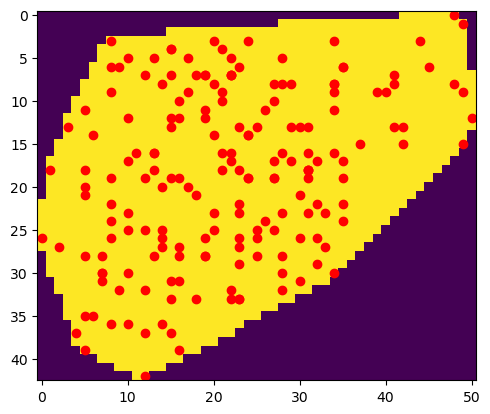

In [236]:
#compare uniform_cell score with plots

adata_sp = adata_exp0
df = adata_sp.uns["spots"]
unique_cell_ids = adata_sp.obs["cell_id"]
adata_sp.obs["uniform_cell"] = np.nan

spots = df.loc[df["cell"] == 1656].copy()
spots["x"], spots["y"] = [spots["x"].round().astype(int), spots["y"].round().astype(int)]      
[x_min, x_max, y_min, y_max] = [spots["x"].min(),spots["x"].max(),spots["y"].min(),spots["y"].max()]
spots["x"], spots["y"] = spots["x"]-x_min, spots["y"]-y_min


seg_mask = np.zeros((x_max-x_min+1,y_max-y_min+1))
seg_mask[spots["x"].values.tolist(), spots["y"].values.tolist()] = 1       #?spot mir Koord. (x,y) wird geplottet bei (y,x)
cell = convex_hull_image(seg_mask)        

plt.imshow(cell)
plt.scatter(spots["y"], spots["x"], color='red')
